#### Use xarray reader to analyze within segment roughness and between segment roughness



In [7]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [22]:
import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy.ma as ma
import h5py
import s3fs
import matplotlib.pyplot as plt
import netCDF4
import xarray as xr
#from scipy import stats
import scipy
import xesmf as xe
# Use seasborn for nicer looking inline plots if available 
#import seaborn as sns
#sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")


ModuleNotFoundError: No module named 'xesmf'

#### Beam selection   
There are 6 beams to choose from in the ICESat-2 products (3 pairs of a strong and weak beam). The energy ratio between the weak and strong beams are  approximately 1:4 and are separated by 90 m in the across-track direction. The beam pairs are separated by ~3.3 km in the across-track direction, and the strong and weak beams are separated by ~2.5 km in the along-track direction.

#### chose a file to read



In [9]:
ATL07file='processed_ATL07-01_20181130235806_09680101_001_01.h5'
ATL07file='processed_ATL07-01_20181206115828_10520101_001_01.h5'
ATL07file='processed_ATL07-01_20181206133245_10530101_001_01.h5'
ATL07file='processed_ATL07-01_20181121010613_08160101_001_01.h5'
localFilePath='/home/jovyan/Data/'+ATL07file


In [10]:
def MakeDataSet(filename, beam='gt1r'):
    ATL07 = h5py.File(localFilePath, 'r')

    # coordinates, start their lives as data arrays
    lons = xr.DataArray(ATL07[beam+'/sea_ice_segments/longitude'][:],dims=['segs'])
    lons.name='lons'
    lats = xr.DataArray(ATL07[beam+'/sea_ice_segments/latitude'][:],dims=['segs'])
    lats.name='lats'
    # add 360 to lons less than 0
    lons360 = lons.where(lons.values>0, other=lons.values+360)

    # this is the time hacked a bit since I am an idiot, it is within seconds
    delta_time=ATL07[beam+'/sea_ice_segments/delta_time'][:] 
    time = np.datetime64('2018-01-01') + (delta_time-86400*0.015).astype('timedelta64[s]' ) 

    # variables in datasets, start their lives as data arrays too
    seg_dist = xr.DataArray(ATL07[beam+'/sea_ice_segments/seg_dist_x'][:],dims=['segs'])
    seg_dist.name = 'seg_dist' # the first two dataarrays have to be named, grr
    #print(set_dist)

    height = xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_height'][:],dims=['segs'])
    height.name = 'height'
    #print('\n\nTake a look at the dataarray we made \n')
    #print(height)
    
    mss = xr.DataArray(ATL07[beam+'/sea_ice_segments/geophysical/height_segment_mss'][:],dims=['segs'])
    seg_length= xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_length_seg'][:],dims=['segs'])
    quality_flag = xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_fit_quality_flag'][:],dims=['segs'])
    isita_lead =   xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:],dims=['segs'])
    gauss_width =   xr.DataArray(ATL07[beam+'/sea_ice_segments/heights/height_segment_w_gaussian'][:],dims=['segs'])

    # start by merging first two datarrays (they have to have names)
    ds=xr.merge([seg_dist, height])

    # now we add more dataarrays 
    ds['mss'] = mss
    ds['seg_length'] = seg_length
    ds['quality_flag'] = quality_flag
    ds['isita_lead'] = isita_lead
    ds['gauss_width'] = gauss_width
    
    ds.coords['lon'] = lons
    ds.coords['lat'] = lats
    ds.coords['time'] = xr.DataArray(time,dims=['segs'])
    ds.coords['delta_time'] = xr.DataArray(delta_time,dims=['segs'])

    ds.coords['lon360'] = lons360
    ds.coords['segs'] = xr.DataArray(np.arange(0,len(height),1),dims=['segs'])

    print('\n\nTake a look at the dataset we made \n')
    print(ds)

    return ds


In [11]:
ds1r = MakeDataSet(localFilePath, beam = 'gt1r')
ds1l = MakeDataSet(localFilePath, beam = 'gt1l')



Take a look at the dataset we made 

<xarray.Dataset>
Dimensions:       (segs: 295184)
Coordinates:
    lon           (segs) float64 -178.5 -178.5 -178.5 -178.5 ... 17.2 17.2 17.2
    lat           (segs) float64 65.29 65.29 65.29 65.29 ... 81.42 81.42 81.42
    time          (segs) datetime64[ns] 2018-11-21T01:01:40 ... 2018-11-21T01:10:20
    delta_time    (segs) float64 2.8e+07 2.8e+07 2.8e+07 ... 2.8e+07 2.8e+07
    lon360        (segs) float64 181.5 181.5 181.5 181.5 ... 17.2 17.2 17.2 17.2
  * segs          (segs) int64 0 1 2 3 4 ... 295179 295180 295181 295182 295183
Data variables:
    seg_dist      (segs) float64 7.28e+06 7.28e+06 ... 1.097e+07 1.097e+07
    height        (segs) float32 3.4028235e+38 3.4028235e+38 ... 0.13038407
    mss           (segs) float32 3.5759127 3.5759127 ... 28.19317 28.196634
    seg_length    (segs) float32 9847.246 4923.269 ... 109.61619 130.14487
    quality_flag  (segs) int8 -1 -1 -1 -1 -1 -1 -1 -1 -1 ... 1 1 1 1 1 1 1 1 1
    isita_lead    (s

In [12]:
#plt.plot(ds1r.lon360,ds1r.lat,'.',ds1l.lon360,ds1l.lat,'.');
#plt.plot(ds1r.seg_dist,ds1r.mss,ds1l.seg_dist,ds1l.mss);
#plt.plot(ds1r.seg_dist,ds1r.isita_lead);
#plt.plot(ds1r.lon360,ds1r.seg_dist);
#plt.plot(ds1r.delta_time);

In [13]:
# Select variable of interest from the dataframe columns
# choices are 'height' or 'seg_dist' or other variables in the dataset
cvar='height'
cvar2='gauss_width' ##'height'
cvar3='seg_length'
cvar4='seg_dist'

lon= ds1r.lon.where((abs(ds1r.height.values)<10)&(abs(ds1r.gauss_width.values)<1))
lat= ds1r.lat.where((abs(ds1r.height.values)<10)&(abs(ds1r.gauss_width.values)<1))
da_1 = ds1r[cvar].where((abs(ds1r.height.values)<10)&(abs(ds1r.gauss_width.values)<1))
da_2 = ds1r[cvar2].where((abs(ds1r.height.values)<10)&(abs(ds1r.gauss_width.values)<1))
da_3 = ds1r[cvar3].where((abs(ds1r.height.values)<10)&(abs(ds1r.gauss_width.values)<1))
da_4 = ds1r[cvar4].where((abs(ds1r.height.values)<10)&(abs(ds1r.gauss_width.values)<1))

lon=lon[~(np.isnan(da_1.values)+np.isnan(da_2.values))]
lat=lat[~(np.isnan(da_1.values)+np.isnan(da_2.values))]
da_t1 = da_1[~(np.isnan(da_1.values)+np.isnan(da_2.values))]
da_t2 = da_2[~(np.isnan(da_1.values)+np.isnan(da_2.values))]
da_t3 = da_3[~(np.isnan(da_1.values)+np.isnan(da_2.values))]
da_t4 = da_4[~(np.isnan(da_1.values)+np.isnan(da_2.values))]
print(len(lon),len(lat),len(da_t1),len(da_t2))

291615 291615 291615 291615


In [14]:
#ds1r[cvar2].where((abs(ds1r.height.values)<10)&(abs(ds1r.gauss_width.values)<1))
len((abs(ds1r.height.values)<10)&(abs(ds1r.gauss_width.values)<1))
len(da_1[~(np.isnan(da_1.values)+np.isnan(da_2.values))])

291615

<xarray.DataArray 'gauss_width' ()>
array(0.99, dtype=float32)


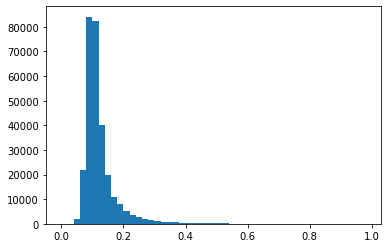

In [15]:
print(np.amax(da_t2))
plt.hist(da_t2, bins=np.arange(0,1,.02));
#plt.hist(da_t3, bins=np.arange(0,80,5));

In [21]:
%matplotlib widget
# Make a new projection "NorthPolarStereo"

plt.figure(figsize=(7,7), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
#plt.scatter(lon, lat, c=da_t2, cmap='coolwarm', vmin=0,vmax=.2,alpha=.5, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());


plt.scatter(lonz,latz,c=ice_type[0],cmap='viridis', vmin=0,vmax=5,transform=ccrs.PlateCarree())
# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())
plt.scatter(lon, lat, c=da_t2, cmap='coolwarm', vmin=0,vmax=.2,alpha=.5, transform=ccrs.PlateCarree())
ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=cvar2, shrink=0.5,  extend='both')
plt.plot(lon.values[500],lat.values[500], 'kX',markersize=10, transform=ccrs.PlateCarree());

FigureCanvasNbAgg()

In [59]:
print(lat.values[0],lon.values[0])

65.31756323648672 -178.53062658322807


In [28]:
#%matplotlib inline
#see if there is a relationship between height and the gaussian width
#plt.plot(da_t2.values[::1000],da_t3.values[::1000], 'bo')
#plt.plot(da_t1.values[::1000],da_t2.values[::1000], 'bo')
#plt.ylim(0,.5)
#slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(da_t1.values,da_t2.values)
#print(slope, intercept, r_value, p_value, std_err)
#r_value is .48 so no.

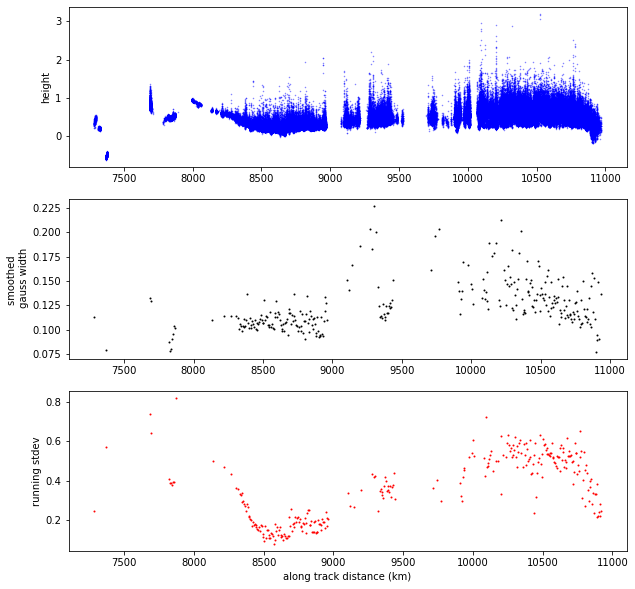

In [81]:
%matplotlib inline
f, ax=plt.subplots(nrows=3,ncols=1,sharex=True, figsize=(10,10))
x = da_t2.values #gaussian width
y = da_t1.values #height
k = (np.ones([1,501])/501)[0]
smoothed = np.convolve(x, k, 'valid')
l=(y[250:-250]-smoothed) ** 2 #  squared error
smoothed2 = np.convolve(l, k, 'valid') #running mean of squared error = variance
#mean( (x-smoothed) ** 2 ) 

ax[0]= plt.subplot(3,1,1)
ax[0].plot(da_t4.values/1000,da_t1.values,'bo',markersize=.5,alpha=.5, label='gauss width')
ax[1]=plt.subplot(3,1,2)
ax[1].plot((da_t4.values/1000)[::1000],smoothed[::1000], 'ko', markersize=1, label='smoothed gauss width')
ax[2] = plt.subplot(3,1,3)
ax[2].plot((da_t4.values/1000)[::1000][:-1],np.sqrt(smoothed2[::1000]), 'ro', markersize=1,label='running stdev of heights')

#plt.ylim(0,2)

ax[0].set_ylabel('height')
ax[1].set_ylabel('smoothed \n gauss width')
ax[2].set_ylabel('running stdev')
ax[2].set_xlabel('along track distance (km)');
#plt.legend(loc=1);

In [18]:

#print(len(smoothed
#plt.plot((da_t4.values/1000)[:100000],smoothed2[:100000], 'k-', label='running stdev');

itype = xr.open_dataset('../../Data/ice_type_nh_polstere-100_multi_201811211200.nc')

#sic=ice_type.sic.values[0]
lonz=itype.lon.values
latz=itype.lat.values
ice_type=itype.ice_type.values
#plt.pcolormesh(dNday['longitude'], dNday['latitude'],ma.masked_where(dNday['iceConc']<0.3, dNday['iceConc']) , cmap='Blues_r', transform=ccrs.PlateCarree())
#print(itype)
#plt.pcolormesh([lon, lat], ice_type,transform=ccrs.PlateCarree())
#itype
#plt.scatter(lonz,latz,c=ice_type[0]);

FigureCanvasNbAgg()

IndexError: index 1 is out of bounds for axis 0 with size 1

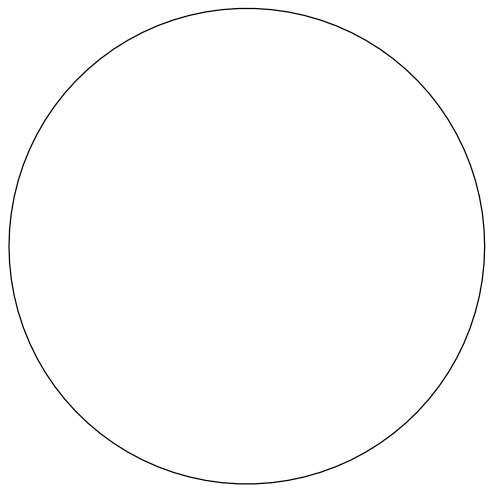

In [144]:
plt.figure(figsize=(7,7), dpi= 90)
good= np.where(~np.isnan(ice_type))
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(lonz[good], latz[good], c=ice_type[good], cmap='coolwarm', vmin=0,vmax=.2,alpha=.5, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label='icetype', shrink=0.5,  extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

In [140]:
len(lonz)

1120

In [141]:
len(latz)

1120

In [143]:
len(ice_type[0])

1120

In [145]:
np.where(~np.isnan(ice_type[0]))

(array([   0,    0,    0, ..., 1119, 1119, 1119]),
 array([  0,   1,   2, ..., 757, 758, 759]))